<div style="background-color:#f6dd95; padding: 6px; border: 12px solid #f6bd95;">

# <a class="anchor" id="0"></a> <b>Части работы<b/>

1. [Общая информация](#1)
2. [Выбор метрики](#2)
3. [Предобработка](#3)
4. [Линейная регрессия](#4)
5. [Линейная регрессия со стандартизацией](#5)
6. [Линейная регрессия с отбором признаков](#6)
7. [Линейная регрессия с преобразованиями](#7)
8. [Random Forest](#8)
9. [Результаты](#9)
10. [Отчет](#10)

<div style="background-color:#f6dd95; padding: 2px">

    
## <a class="anchor" id="1"></a> Общая информация
[Оглавление](#0)

Датасет: Happiness Index 2018-2019 <br>
Целевая переменная: Score

О данных: В датасете анализируется связь между показателем индекса счастья в 2018 и 2019 годах и набором независимых переменных (в т.ч. общий рейтинг, ВВП на душу населения, социальная поддержка, ожидаемая продолжительность здоровой жизни, свобода делать жизненный выбор, щедрость и восприятие коррупции). 

| Название                      | Описание                                                  |
|-------------------------------|-----------------------------------------------------------|
| Overall rank                  | Общий рейтинг: Список рейтингов разных стран от 1 до 15 6 |
| Country or region             | Страна или регион: список названий разных стран           |
| Score                         | Оценка: список оценок счастья разных стран                |
| GDP per capita                | ВВП на душу населения: показатель ВВП на душу населения   |
| Social support                | Социальная поддержка: социальная поддержка стран          |
| Healthy life expectancy       | Ожидаемая продолжительность здоровой жизни                |
| Freedom to make life choices  | Свобода делать жизненный выбор: восприятие свобо  ды      |
| Generosity                    | Щедрость: качество быть добрым и великодушным             |
| Perceptions of corruption     | Восприятие коррупции: оценка коррупции в страна х         |

Как было отмечено ранее, в качестве целевой переменной мы выделили **Score**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pointbiserialr
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error

import warnings
import shap

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

In [2]:
data = pd.read_csv('Happiness Index 2018-2019.csv')
data.head(3)

,Overall rank,Country or region,Year,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,154,Afghanistan,2019,3.203,0.350,0.517,0.361,0.000,0.158,0.025
1,145,Afghanistan,2018,3.632,0.332,0.537,0.255,0.085,0.191,0.036
2,107,Albania,2019,4.719,0.947,0.848,0.874,0.383,0.178,0.027


<div style="background-color:#f6dd95; padding: 2px">

    
## <a class="anchor" id="2"></a> Выбор метрики
[Оглавление](#0)

Для сравнения моделей мы будем использовать скорректированный коэффициент детерминации, по следующим причинам: <br>
- Скорректированный $R^2$ учитывает количество объясняющих переменных в модели, что помогает сравнивать модели с разным количеством признаков-факторов: так, если добавление новых переменных не улучшает модель, то штраф, накладываемый $R^2_{adj}$, покажет это;
- Благодаря количеству объясняющих переменных, которые включены в формулу расчета данной метрики, можно сравнивать модели с разным числом параметров;
- Кроме того, скорректированный $R^2$ можно использовать и при сравнении моделей с разными функциональными формами. По большинству других метрик проводить такое сравнение было бы некорректно из-за указанных различий в спецификации - $R^2_{adj}$ не зависит от масштаба данных;
- $R^2_{adj}$ показывает качество аппроксимации модели, а также измеряется в определенных границах ( [0; 1] ), что также упростит выявление наилучшей модели

Формула расчета скорректированного $ R^2 $ <br>

$$
R^2_{adj} = 1 - \frac{(1 - R^2) \cdot (n - 1)}{n - m - 1}
$$

где:
- $ R^2 = 1 - \frac{SS_{\text{факт}}}{SS_{\text{общ}}} $ — обычный коэффициент детерминации,
- $ SS_{\text{факт}} = \sum (y_i - \hat{y}_i)^2 $ — факторная сумма квадратов (сумма квадратов остатков),
- $ SS_{\text{общ}} = \sum (y_i - \bar{y})^2 $ — общая сумма квадратов (вариация фактических значений относительно среднего),
- $ n $ — количество наблюдений,
- $ m $ — количество объясняющих переменных в модели.

<div style="background-color:#f6dd95; padding: 2px">

    
## <a class="anchor" id="3"></a> Проведем предобработку датасета
[Оглавление](#0)

и переименуем столбы для дальнейшего удобства

In [3]:
data.columns = data.columns.str.lower()
data.head(1)

,overall rank,country or region,year,score,gdp per capita,social support,healthy life expectancy,freedom to make life choices,generosity,perceptions of corruption
0,154,Afghanistan,2019,3.203,0.350,0.517,0.361,0.000,0.158,0.025


In [4]:
data.info() #проверяем пропуски и типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   overall rank                  312 non-null    int64  
 1   country or region             312 non-null    object 
 2   year                          312 non-null    int64  
 3   score                         312 non-null    float64
 4   gdp per capita                312 non-null    float64
 5   social support                312 non-null    float64
 6   healthy life expectancy       312 non-null    float64
 7   freedom to make life choices  312 non-null    float64
 8   generosity                    312 non-null    float64
 9   perceptions of corruption     312 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 24.5+ KB


Мы видим, что датасет не содержит пропусков, а типы данных не требуют изменения. <br>
Кроме того, из исследования нужно будет исключить название страны и региона - данный столбец не является числовым и содержит слишком много уникальных данных.

In [5]:
data = data.drop(['country or region'], axis=1)

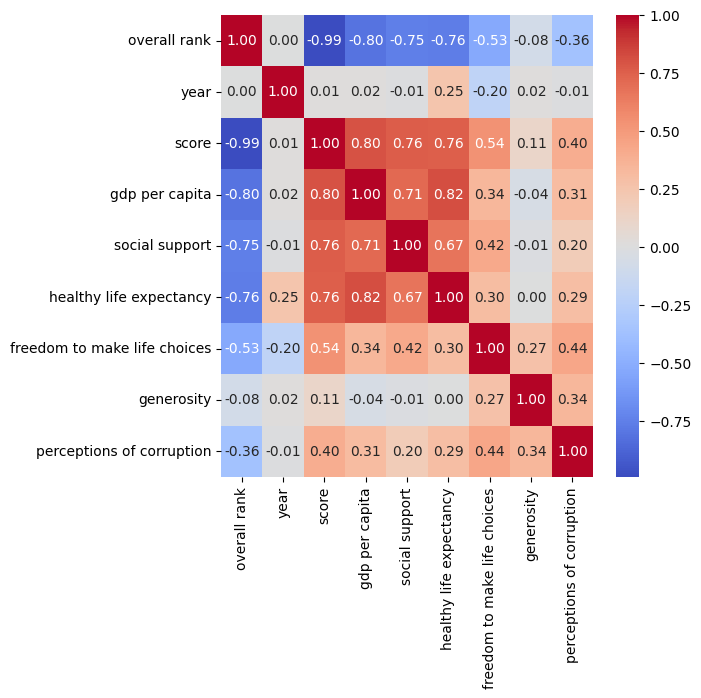

In [6]:
plt.figure(figsize=(6, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [7]:
data.corr()['score']

overall rank                   -0.990
year                            0.014
score                           1.000
gdp per capita                  0.798
social support                  0.761
healthy life expectancy         0.756
freedom to make life choices    0.540
generosity                      0.107
perceptions of corruption       0.397
Name: score, dtype: float64

отдельно проверим, имеет ли смысл оставлять в дальнейшем исследовании год: закодируем: 2018 на 0, 2019 - на 1 и проверим точечно-бисериальную корреляцию между ним и целевой переменной. Применение точечно-бисериальной корреляции обусловлено тем, что номер года - бинарная переменная, а целевая переменная - количественная непрерывная

In [8]:
data['year_enc'] = data['year'].map({2018: 0, 2019: 1})

In [9]:
corr, p_value = pointbiserialr(data['year_enc'], data['score'])

print(f"Точечно-бисериальная корреляция: {corr:.3f}")
print(f"P-значение: {p_value:.3f}")

Точечно-бисериальная корреляция: 0.014
P-значение: 0.805


Мы видим, что значение коэффициента корреляции все равно осталось низким - удалим год из дальнейшего исследования

In [10]:
data = data.drop(['year', 'year_enc'], axis=1)
data.head(1)

,overall rank,score,gdp per capita,social support,healthy life expectancy,freedom to make life choices,generosity,perceptions of corruption
0,154,3.203,0.350,0.517,0.361,0.000,0.158,0.025


Далее проанализируем значения коэффициентов корреляции факторных признаков с целевой переменной

In [11]:
data.corr()['score']

overall rank                   -0.990
score                           1.000
gdp per capita                  0.798
social support                  0.761
healthy life expectancy         0.756
freedom to make life choices    0.540
generosity                      0.107
perceptions of corruption       0.397
Name: score, dtype: float64

мы видим черезчур высокое значение коэффициента корреляции между score и overall rank (посмотрим на их взаимосвязь через pairplot), кроме того, мы видим тесную связь между целевой переменной и следующими факторными показателями: ВВП на душу населения (gdp per capita), социальная поддержка (social support), ожидаемая продолжительность здоровой жизни (healthy life expectancy). Также отметим заметную связь со свободой делать жизненный выбор (freedom to make life choices); умеренная связь отмечается с восприятием коррупции (perceptions of corruption) и слабая - со щедростью (generosity).

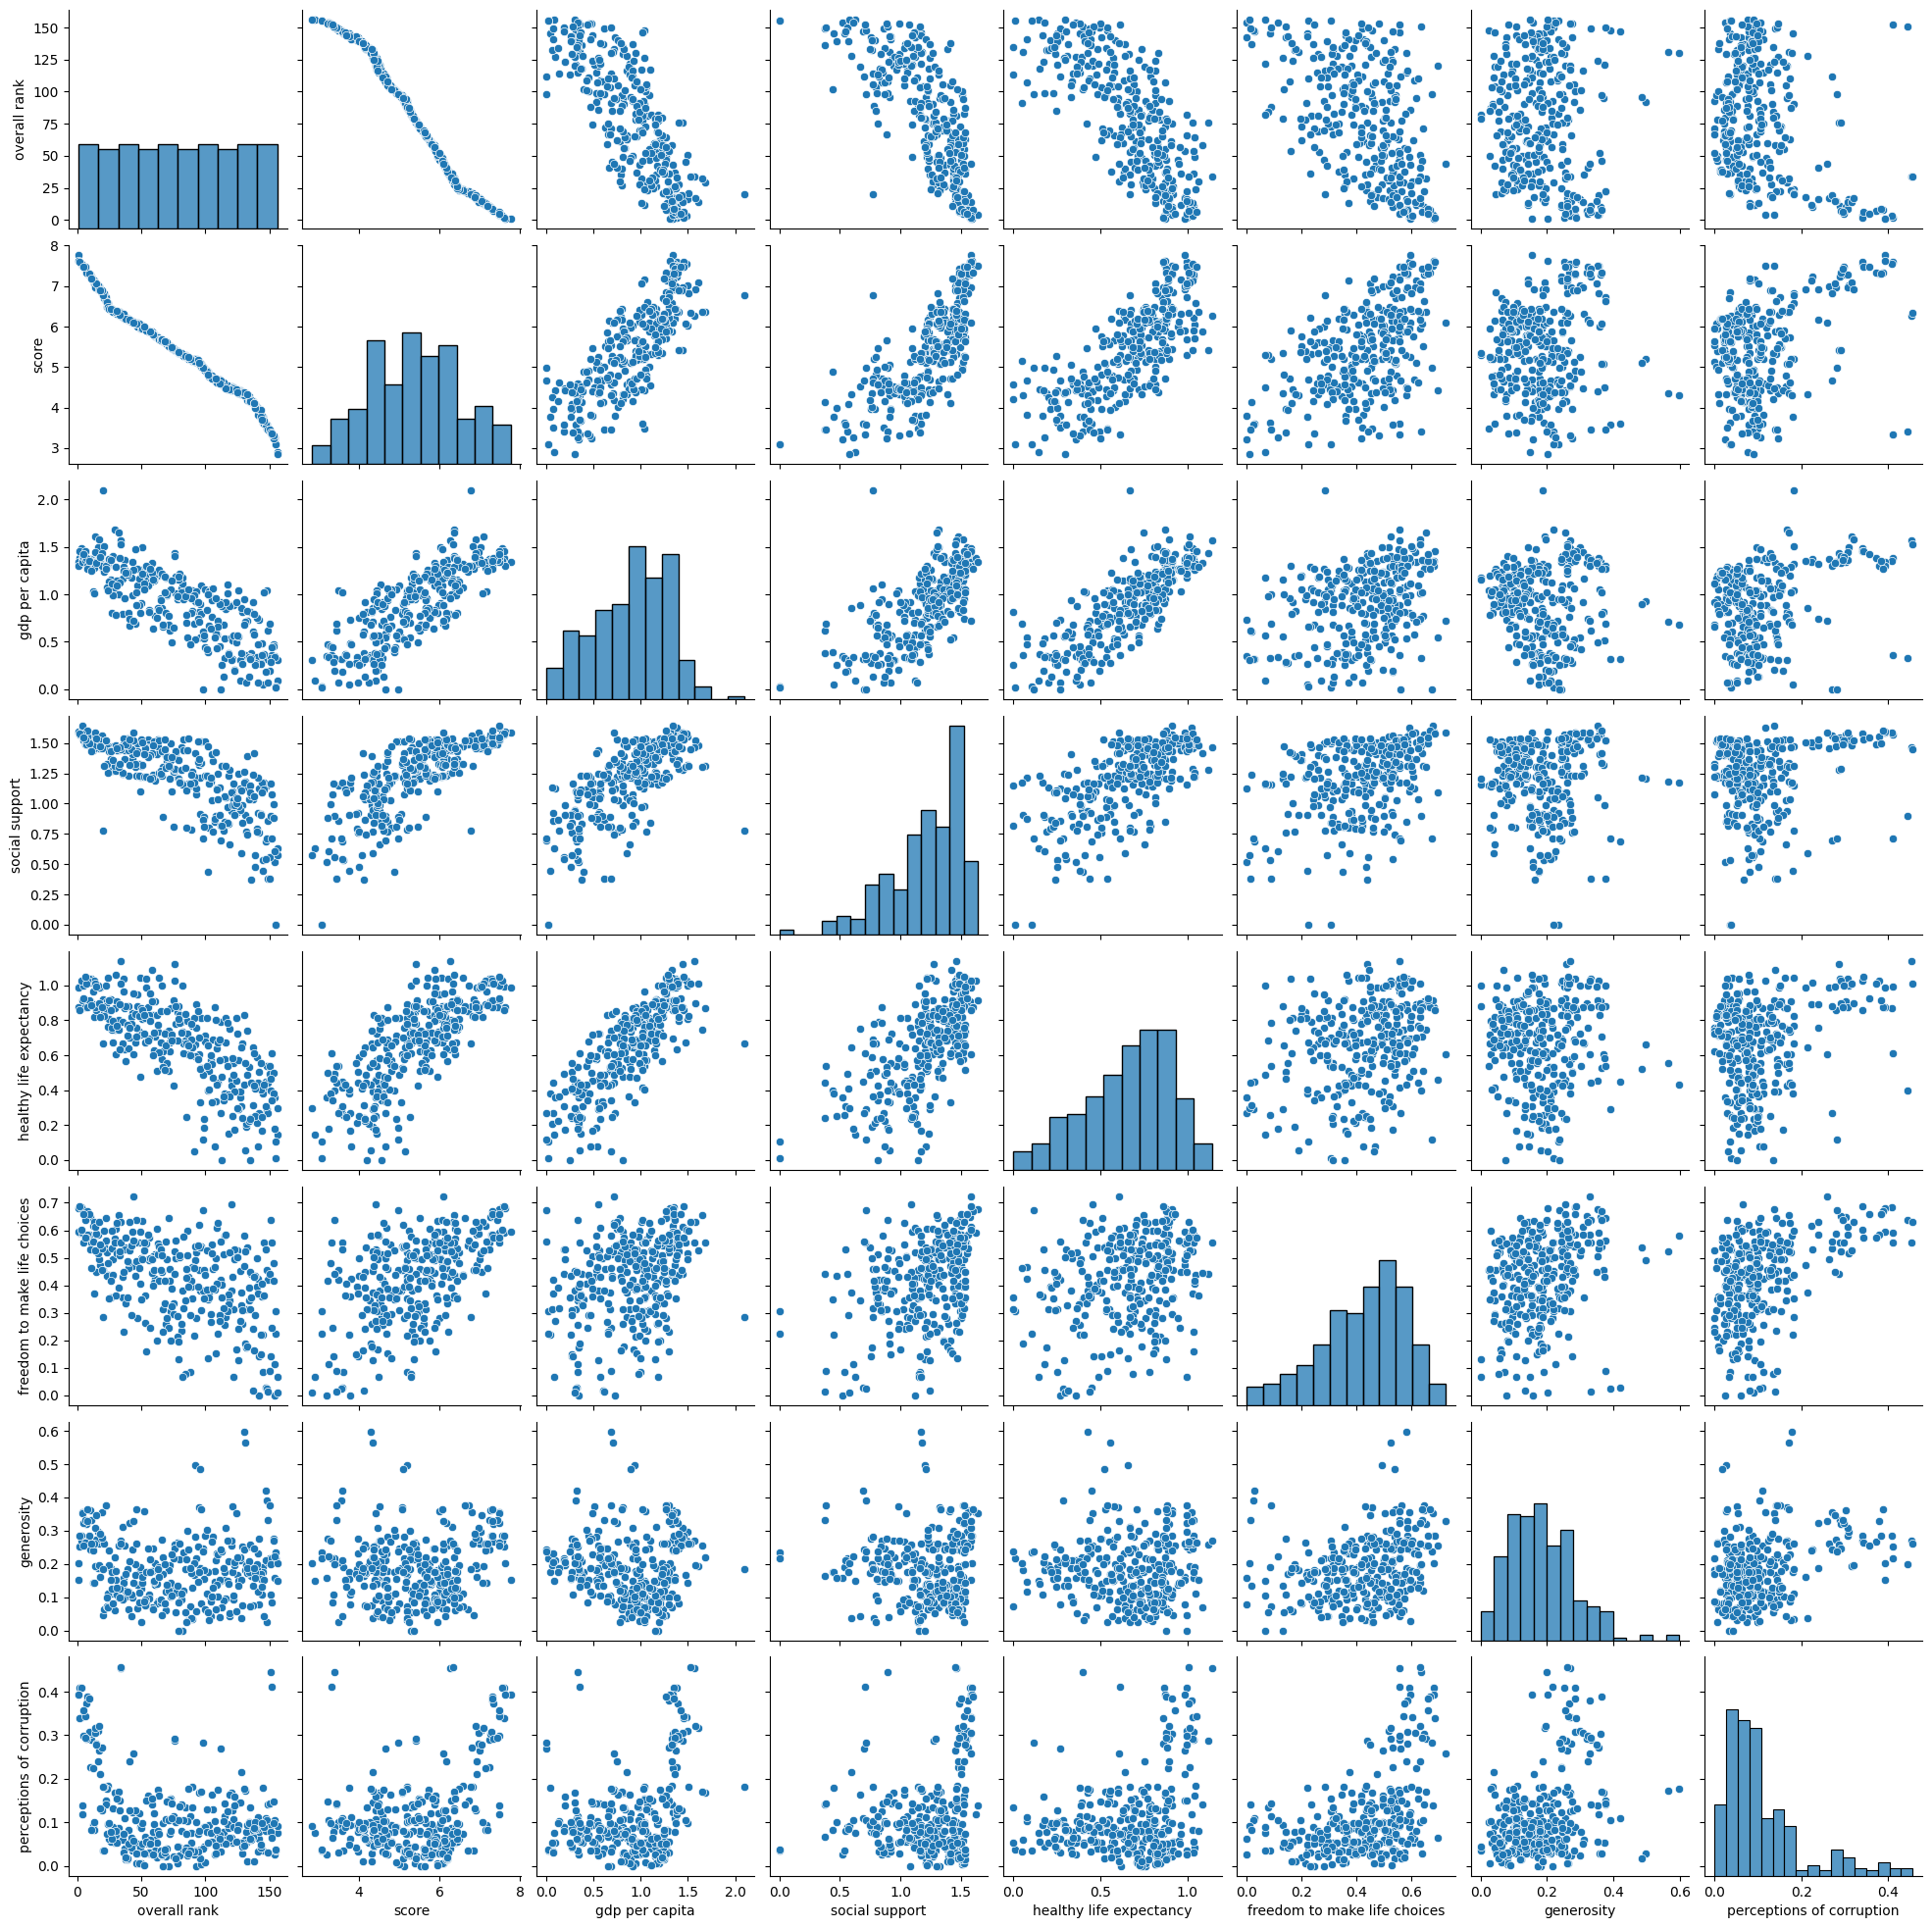

In [12]:
#построим pairplot
sns.pairplot(data)
plt.show()

мы видим, что ранги практически повторяют столбец score, удалим данный столбец - чтобы он не искажал результаты построения регрессии 

кроме того, график pairplot не отражает ярко выраженной нелинейной связи с целевой переменной (кроме, может быть perception of corruption)

In [13]:
data = data.drop(['overall rank'], axis=1)

Также рассмотрим распределения данных по каждому оставшемуся в исследовании столбцу: для этого построим графики:

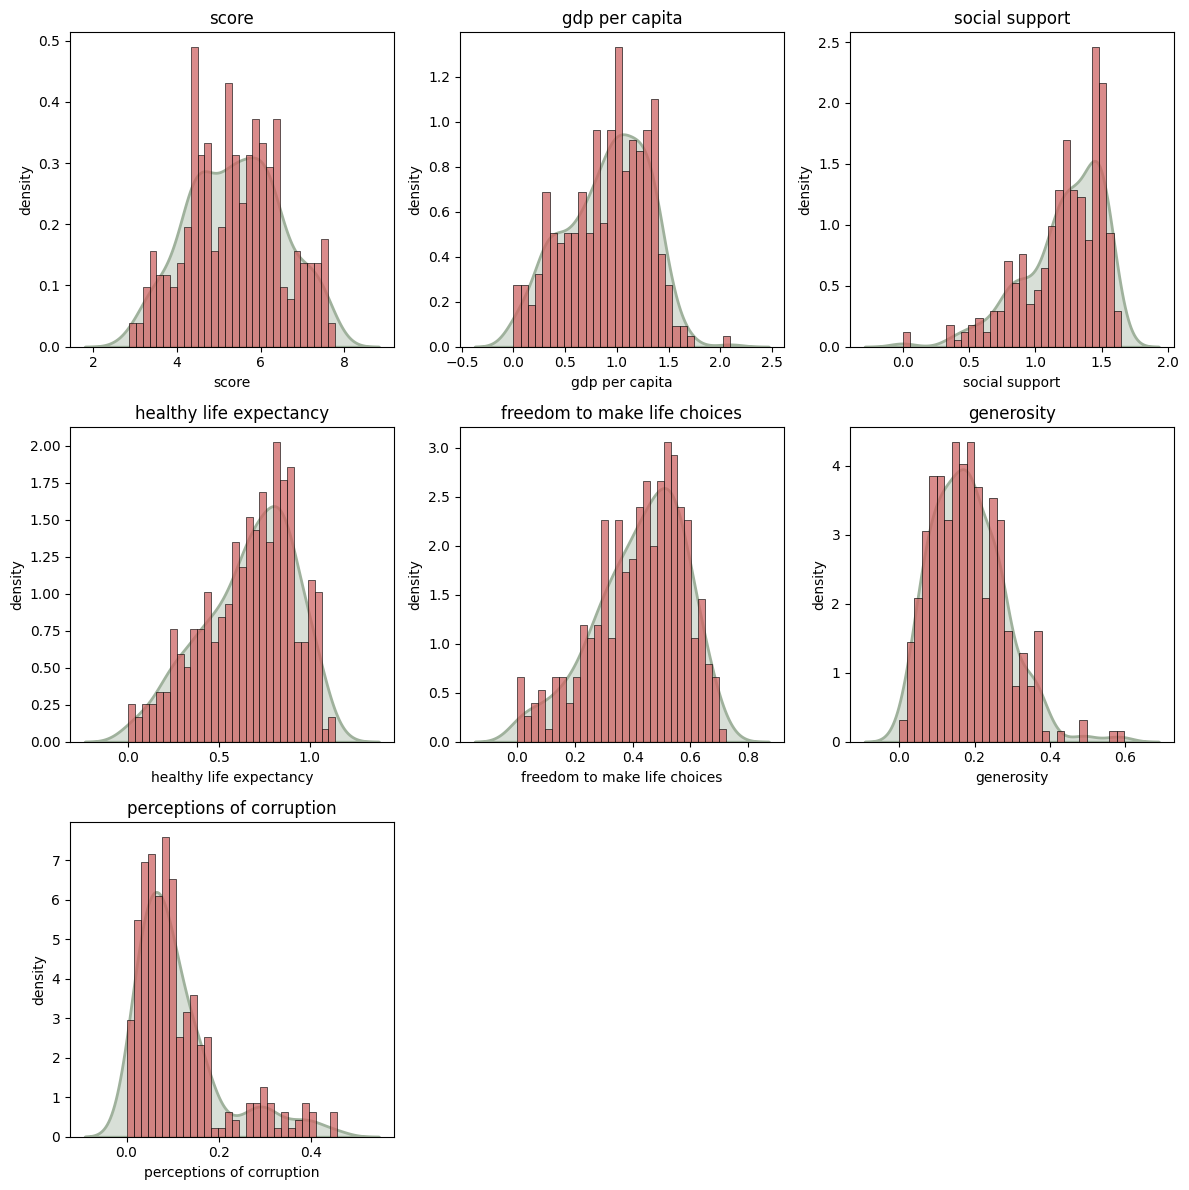

In [14]:
columns = data.columns


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.kdeplot(data[col], ax=axes[i], color='#9fb19c', fill=True, alpha=0.4, linewidth=2)
    sns.histplot(data[col], ax=axes[i], bins=30, color='#ce6565', edgecolor='black', stat='density')
    
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('density')

for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

На графиках мы не видим нормального распределения ни на одном из графиков - при построении линейной регрессии приведение к нормальному виду может улучшить результаты (помимо этого, мы воспользуемся и стандартизацией)

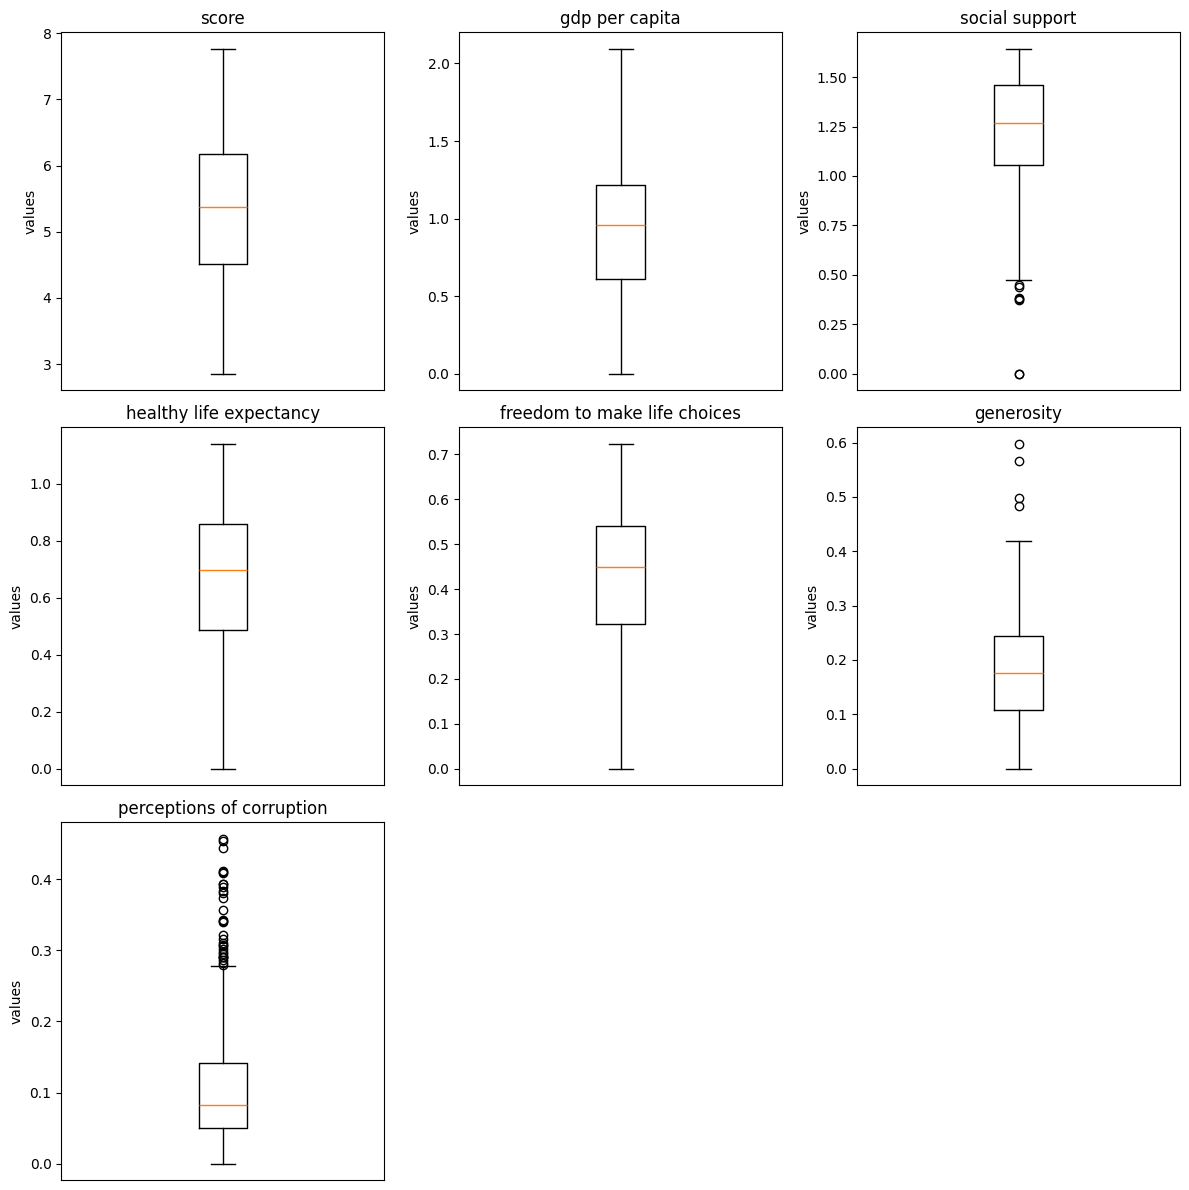

In [15]:
columns = data.columns


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(columns):
    axes[i].boxplot(data[col])
    
    axes[i].set_title(col)
    axes[i].xaxis.set_visible(False)
    axes[i].set_ylabel('values')

for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Мы видим, что выбросы есть только у трех столбцов: social support, generosity, perceptions of corruption - однако мы приняли решение не удалять выбросы, так как они вызваны спецификой тех или иных стран, и не являются, например, ошибками заполнения или расчетов.

<div style="background-color:#f6dd95; padding: 2px">

    
## <a class="anchor" id="4"></a> Линейная регрессия
[Оглавление](#0)

In [16]:
df = data.copy()

In [17]:
X = df.drop(['score'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
n = len(y_test)
m = X_test.shape[1] 

r2_simple_linear_regression = 1 - (1 - r2) * (n - 1) / (n - m - 1)
round(r2_simple_linear_regression, 3)

0.723

Данный результат можно назвать достаточно хорошим, однако проведем дополнительные преобразования для улучшения результатов

Для начала, проведем нормализацию с помощью StandatdScaler

<div style="background-color:#f6dd95; padding: 2px">

    
## <a class="anchor" id="5"></a> Линейная регрессия со стандартизацией
[Оглавление](#0)

In [18]:
scaler = StandardScaler()

Мы выбрали StandardScaler по ряду причин, некоторые из которых представлены ниже:
- помогает преобразовать все признаки к общему масштабу с нулевым средним и единичной дисперсией
- используется в том числе, когда данные не имеют нормального распределения
- стандартизация приводит данные к единому масштабу (независимо от исходных единиц измерения)
- благодаря стандартизации многие алгоритмы работают лучше или сходятся быстрее когда признаки примерно одинакового масштаба и нормально или почти нормально распределены

In [19]:
X = df.drop(['score'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
n = len(y_test)
m = X_test.shape[1] 

r2_linear_regression_standardized = 1 - ((1 - r2) * (n - 1)) / (n - m - 1)
round(r2_linear_regression_standardized, 3)

0.695

Мы видим, что стандартизация только ухудшила результат расчета скорректированного коэффициента детерминазии - качество аппроксимации снизилось

Попробуем произвести отбор признаков

<div style="background-color:#f6dd95; padding: 2px">

    
## <a class="anchor" id="6"></a> Линейная регрессия с отбором признаков
[Оглавление](#0)

Для отбора признаков воспользуемся значениями Шепли. 

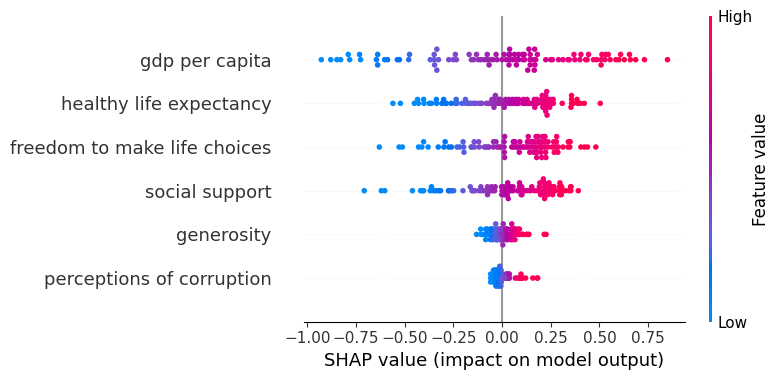

In [20]:
X = df.drop(['score'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
explainer = shap.Explainer(reg, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

По графику мы видим подтверждение выводов, которые мы делали при рассмотрении коэффициентов корреляции. Наиболее важным в соответствии со значениями Шепли оказался ВВП на душу населений; другими важными признаками оказались рассмотренные ранее признаки: социальная поддержка (social support), ожидаемая продолжительность здоровой жизни (healthy life expectancy). Также отметим заметную связь со свободой делать жизненный выбор (freedom to make life choices); умеренная связь отмечается с восприятием коррупции (perceptions of corruption) и слабая - со щедростью (generosity) <br>
Попробуем проверить различные сочетания признаков generosity и perceptions of corruption для исключения из модели: в соответствии со значениями Шепли они имеют наименьший вес

In [21]:
df.head(1)

,score,gdp per capita,social support,healthy life expectancy,freedom to make life choices,generosity,perceptions of corruption
0,3.203,0.350,0.517,0.361,0.000,0.158,0.025


In [22]:
X = df.drop(['score', 'perceptions of corruption'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2_c = r2_score(y_test, y_pred)
n = len(y_test)
m = X_test.shape[1] 

r2_linear_regression_without_corruption = 1 - ((1 - r2_c) * (n - 1)) / (n - m - 1)
round(r2_linear_regression_without_corruption, 3)

0.717

Мы получили результат, худший по сравнению со случаем включения всех факторов в модель (хотя и незначительно). Проверим случай исключения признака generosity

In [23]:
X = df.drop(['score', 'generosity'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2_g = r2_score(y_test, y_pred)
n = len(y_test)
m = X_test.shape[1] 

r2_linear_regression_without_generocity = 1 - ((1 - r2_g) * (n - 1)) / (n - m - 1)
round(r2_linear_regression_without_generocity, 3)

0.729

Получили, что данная модель в соответствии с $R^2$ имеет наилучшее качество аппроксимации (хотя он лучше простой линейной регрессии всего на 0,003). Проверим также случай исключения одновременно perceptions of corruption и generosity

In [24]:
X = df.drop(['score', 'perceptions of corruption', 'generosity'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2_b = r2_score(y_test, y_pred)
n = len(y_test)
m = X_test.shape[1] 

r2_linear_regression_without_both = 1 - ((1 - r2_b) * (n - 1)) / (n - m - 1)
round(r2_linear_regression_without_both, 3)

0.72

Данный результат тоже можно назвать достаточно хорошим, однако он немного ниже случая с простой линейной регрессией и линейной регрессией с удалением generosity. Попробуем добавить стандартизацию в рассмотрение предыдущего случая

In [25]:
X = df.drop(['score', 'generosity'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2_st = r2_score(y_test, y_pred)
n = len(y_test)
m = X_test.shape[1] 

r2_st_linear_regression_without_generocity = 1 - ((1 - r2_st) * (n - 1)) / (n - m - 1)
round(r2_st_linear_regression_without_generocity, 3)

0.702

Как и в случае рассмотрения всех признаков, при добавлении стандартизации значение скорректированного $R^2$ только снизилось. Можно говорить о том, что при рассмотрении либо простой линейной регрессии (либо линейной регрессии на стандартизованных данных) мы не получили какого-либо результата, сильно отличающегося от того, что мы получили при простой линейной регрессии. Наилучшим результатом оказалась следующая модель: простая линейная регрессия на всех признаках, кроме generocity - и тех, что мы удалили на этапе предобработки. Для этой модели мы получили значение скорректированного коэффициента детерминации, равное 0,729 - для наилучшей модели в конце работы мы рассмотрим и другие метрики. <br>
Однако для начала попробуем другие преобразования, например, логарифмирование

<div style="background-color:#f6dd95; padding: 2px">

    
## <a class="anchor" id="7"></a> Линейная регрессия с преобразованиями
[Оглавление](#0)

Рассмотрим два случая логарифмирования признаков факторов: случай с использованием всех признаков и, в случае, если результат окажется достаточно хорошим, всех признаков, кроме generosity

In [26]:
#логарифмирование признаков
df1 = df.drop(['score'], axis=1)
y = df['score']

#чтобы избежать ошибок, проверим наличие отрицательных значений
if (df1 < 0).any().any():
    raise ValueError('необходимо обработать отрицательные значения')

# проведем логарифмирование
transformed_df1 = np.log1p(df1)
X_train, X_test, y_train, y_test = train_test_split(transformed_df1, y, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2_l = r2_score(y_test, y_pred)
n = len(y_test)
m = X_test.shape[1] 

r2_linear_regression_with_log = 1 - ((1 - r2_l) * (n - 1)) / (n - m - 1)
round(r2_linear_regression_with_log, 3)

0.704

Мы видим, что после логарифмирования качество аппроксимации снизилось - на наш взгляд, нет смысла убирать показатель generocity - в прошлые разы мы видели, что результаты хоть и увеличились, но незначительно. Рассмотрим другие преобразования и начнем с Бокса-Кокса.

In [27]:
from scipy.stats import boxcox
def boxcox_trans(df):
    #добавим преобразование series в dataframe
    if isinstance(df, pd.Series):
        df = df.to_frame()

    df_trans = df.copy()
    lambdas = {} 

    for i in df.columns:  # Применяем только к числовым данным
        if (df[i] <= 0).any():
            med_value = df[i][df[i] > 0].median() 
            df_trans[i] = df[i].apply(lambda x: med_value if x <= 0 else x) 

        if df_trans[i].nunique() < 2:
            lambdas[i] = None
            continue
            
        df_trans[i], lambda_ = boxcox(df_trans[i])
        lambdas[i] = lambda_ 

    #возвратим обратно в series
    if isinstance(df, pd.Series):
        return df_trans.iloc[:, 0], lambdas

    return df_trans, lambdas

In [28]:
df_bc, lambdas_X = boxcox_trans(df.drop(['score'], axis=1))
y_bc, lambdas_y = boxcox_trans(df['score'])
X_train, X_test, y_train, y_test = train_test_split(df_bc, y_bc, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2_bc = r2_score(y_test, y_pred)
n = len(y_test)
m = X_test.shape[1] 

r2_linear_regression_bc = 1 - ((1 - r2_bc) * (n - 1)) / (n - m - 1)
round(r2_linear_regression_bc, 3)

0.727

Мы получили почти лучший результат, хотя он лишь немногим выше предыдущих рассмотренных моделей (качество аппроксимации сравнимо лишь со случаем исключения факторной переменной generosity - посмотрим, что будет, если исключить из рассмотрения данный признак)

In [29]:
df_bc, lambdas_X = boxcox_trans(df.drop(['score', 'generosity'], axis=1))
y_bc, lambdas_y = boxcox_trans(df['score'])
X_train, X_test, y_train, y_test = train_test_split(df_bc, y_bc, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2_bcg = r2_score(y_test, y_pred)
n = len(y_test)
m = X_test.shape[1] 

r2_linear_regression_bc_without_generosity = 1 - ((1 - r2_bcg) * (n - 1)) / (n - m - 1)
round(r2_linear_regression_bc_without_generosity, 3)

0.734

В соответствии со скорректированным $R^2$ модель с преобразованными факторными признаками имеет наилучшее качество аппроксимации, почти на 0,01 выше, чем предыдущий наилучший рассмотренный вариант.

Кроме того, построим и модель регрессии на основе RandomForestRegressor - он строит несколько деревьев решений, каждое из которых обучается на определенной подвыборке, после чего проводится усреднение

<div style="background-color:#f6dd95; padding: 2px">

    
## <a class="anchor" id="8"></a> Random Forest
[Оглавление](#0)

In [30]:
from sklearn.ensemble import RandomForestRegressor

df1 = df.drop(['score'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rfr = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rfr)
n = len(y_test)
m = X_test.shape[1] 

r2_random_forest = 1 - ((1 - r2_rf) * (n - 1)) / (n - m - 1)
round(r2_random_forest, 3)

0.77

Мы видим, что данная модель оказалась наилучшей (с точки зрения качества аппроксимации в соответствии со скорректированным коэффициентом детерминации). <br>
Данный вывод имеет и обоснования. Так, RandomForestRegressor имеет несколько положительных черт: <br>
- алгоритм устойчив к переобучению;
- не требует стандартизации признаков, поскольку не чувствителен к масштабу данных - в отличие от линейной регрессии;
- лучше работает с выбросами в сравнении с линейной регрессией;


Так, мы получили модель, у которой скорректированный коэффициент детерминации составил 0,77

<div style="background-color:#f6dd95; padding: 2px">

    
## <a class="anchor" id="9"></a> Результаты
[Оглавление](#0)

In [31]:
model_names = [
    'Простая линейная регрессия на всех признаках',
    'Линейная регрессия на стандартизованных признаках',
    'Линейная регрессия (без фактора Perceptions of corruption)',
    'Линейная регрессия (без фактора generocity)',
    'Линейная регрессия (без факторов Perceptions of corruption и generocity)',
    'Линейная регрессия с отобранными стандартизованными факторами (без generocity)',
    'Линейная регрессия с логарифмированными признаками',
    'Линейная регрессия с преобразованием Бокса-Кокса',
    'Линейная регрессия с преобразованием Бокса-Кокса (без generocity)',
    'Модель случайного леса']

results = [
    r2_simple_linear_regression,
    r2_linear_regression_standardized,
    r2_linear_regression_without_corruption,
    r2_linear_regression_without_generocity,
    r2_linear_regression_without_both,
    r2_st_linear_regression_without_generocity,
    r2_linear_regression_with_log,
    r2_linear_regression_bc,
    r2_linear_regression_bc_without_generosity,
    r2_random_forest]

pd.set_option('display.max_colwidth', 200)

results = pd.DataFrame({'Названия моделей': model_names,
                         'Результат по скорректированному R^2': results})

results.sort_values(by='Результат по скорректированному R^2', ascending=False)

,Названия моделей,Результат по скорректированному R^2
9,Модель случайного леса,0.770
8,Линейная регрессия с преобразованием Бокса-Кокса (без generocity),0.734
3,Линейная регрессия (без фактора generocity),0.729
7,Линейная регрессия с преобразованием Бокса-Кокса,0.727
0,Простая линейная регрессия на всех признаках,0.723
4,Линейная регрессия (без факторов Perceptions of corruption и generocity),0.720
2,Линейная регрессия (без фактора Perceptions of corruption),0.717
6,Линейная регрессия с логарифмированными признаками,0.704
5,Линейная регрессия с отобранными стандартизованными факторами (без generocity),0.702
1,Линейная регрессия на стандартизованных признаках,0.695


Выводы.

Мы рассмотрели несколько моделей, лучшая из которых имеет скорректированный $R^2$, равный 0,77 - это оказалась модель случайного леса. Для нее рассмотрим несколько других метрик для оценки качества модели.

In [32]:
round(r2_rf, 4)

0.7815

Так, благодаря коэффициенту детерминации можем сказать, что в соответствии с моделью случайного леса, которую мы построили, вариация объясняющих переменных объясняет 78,15% вариации показателя Score - оценки страны (или региона) в соответствующий год - это является довольно хорошим показателем

Построим также график зависимости

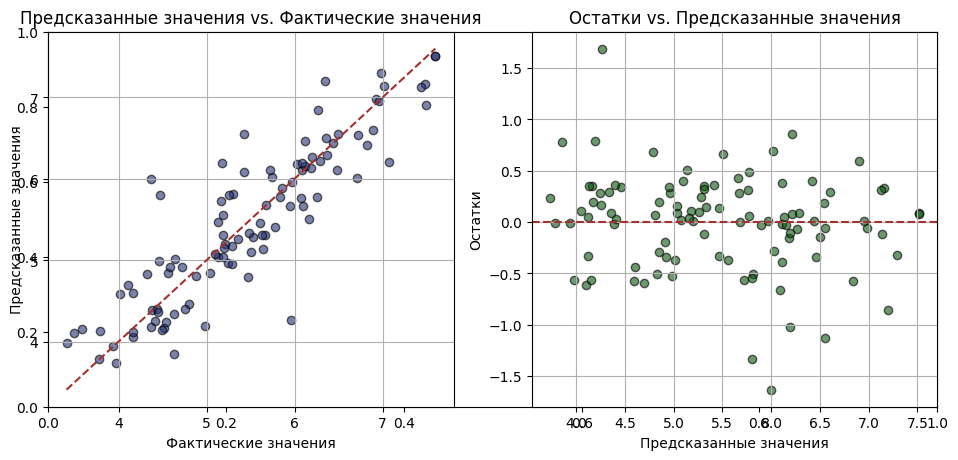

In [38]:
from scipy import stats as st
y = y_test.copy()
y_pred = y_pred_rfr.copy()
residuals = y - y_pred

plt.subplots(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y, y_pred, color='#233074', alpha=0.6, edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], linestyle='--', color='#a53030', linewidth=1.5)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения vs. Фактические значения')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, color='#0b540c', alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='#a53030', linestyle='--', linewidth=1.5)
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs. Предсказанные значения')
plt.grid(True)

plt.tight_layout()
plt.show()

По графику также видно, что модель имеет хорошее качество аппроксимации (а по второму можно говорить и про хорошее качество остатков)

In [35]:
df1 = df.drop(['score'], axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)
round(mape, 4)

0.0661

Это означает, что в среднем модель ошибается на 6,6% от фактических значений при предсказании - довольно низкое значение показателя.

Таким образом можно сделать вывод о том, что мы получили достаточно хорошую модель, адекватно описывающую оценку страны (или региона) по результатам исследования индекса счастья за 2018-2019 годы. В соответствии с данной моделью, значения оценки описываются следующими факторными признаками: ВВП на душу населения, социальная поддержка, ожидаемая продолжительность здоровой жизни, свобода делать жизненный выбор, щедрость и восприятие коррупции. Наилучшей моделью оказалась модель случайного леса (что же касается линейной регрессии, можно выделить линейную регрессию на преобразованных по методу Бокса-Кокса данных - с исключением столбца generocity; однако можно сказать, что большая часть оставшихся рассмотренных моделей имеет примерно одинаковое качество аппроксимации).

<div style="background-color:#f6dd95; padding: 2px">

    
## <a class="anchor" id="10"></a> Отчет
[Оглавление](#0)

В данной работе необходимо было построить модель, способную адекватно предсказывать индекс счастья страны или региона на основе социально экономических факторов - датасет "Happiness Index 2018-2019".
<br>
В данном датасете в качестве целевой переменной мы выбрали столбец 'score' -  список показателей счастья в разных странах. Помимо этого, в датасете присутствовали следующие признаки: <br>
- Overall rank - общий рейтинг разных стран,
- Country or region - список название разных стран,
- GDP per capita – ВВП на душу населения,
- Social support – уровень социальной поддержки разных стран,
- Healthy life expectancy – ожидаемая продолжительность здоровой жизни в разных странах,
- Freedom to make life choices – свобода жизненного выбора в разных странах,
- Generosity – оценка щедрости (/великодушия) населения в разных странах,
- Perceptions of corruption – оценка восприятия коррупции в разных странах.


После загрузки датасета мы приступили к выбору метрики, с помощью которой будем проводить сравнение моделей. В качестве такой метрики мы выбрали скорректированный коэффициент детерминации ($Adjusted$ $R^2$), что можно обосновать следующими выделенными нами факторами:
- $R^2_{adj}$ учитывает количество признаков в модели, в отличие от большинства остальных метрик;
- $R^2_{adj}$ позволяет сравнивать модели разной сложности (вытекает из предыдущего пункта);
- $R^2_{adj}$ легко интерпретируем, поскольку он не может превысить 1, а при адекватном соотношении наблюдений и факторов изменяется в границах [0; 1] (если же число факторов превысит число наблюдений, значение метрики может стать отрицательным);
- $R^2_{adj}$ подходит для сравнения моделей с разными типами функциональных связей - из-за особенностей вычисления $R^2$ для нелинейных моделей.

После выбора метрики мы перешли к предобработке датасета <br>
Сначала мы переименовали столбцы - перевели в нижний регистр, а после проверили пропуски в данных и типы каждого столбца. Пришли к выводу о том, что пропущенных значений нет и работа с типами также не требуется. <br>
Далее мы решили исключить столбец, содержащий данные о стране (или регионе), поскольку он содержит номинальные данные. При этом кодирование, на наш взгляд, не имеет особого смысла, так как число уникальных значений достаточно высоко и мы столкнемся с проблемой слишком большого числа факторов при малом числе наблюдений. <br>
Далее мы построили корреляционную матрицу (ее тепловую карту) и увидели, что номер года практически не коррелирует с целевой переменной. Дополнительно мы проверили и точечно-бисериальную корреляцию - однако и она показала отсутствие связи между годом и оценкой показателя счастья - поэтому мы приняли решение об удалении и этого столбца. <br>
Кроме того, из тепловой карты матрицы корреляций мы увидели и очень тесную обратную связь между общим рейтиргом страны и таргетной переменной - это обусловлено тем, что ранги распределены в соответствии с выставленными оценками. Поэтому столбец "Overall rank" мы также удалили - иначе он бы искажал результаты исследования и влияние прочих факторов на целевую переменную стало бы незначимым. <br>
Кроме того, мы видим тесную связь между 
целевой переменной и следующими факторными показателями: ВВП на душу населения (gdp per capita), социальная поддержка (social support), ожидаемая продолжительность здоровой жизни (healthy life expectancy). Также отметим заметную связь со свободой делать жизненный выбор (freedom to make life choices); умеренная связь отмечается с восприятием коррупции (perceptions of corruption) и слабая - со щедростью (generosity) <br>
Напоследок мы проверили распределение данных (ни один из столбцов не оказался распределен нормально в соответствии с kdeplot и hist) и наличие выбросов (небольшое число оказалось в столбце с социальной поддержкой - в некоторых странах ее уровень был почти нулевым; немногим больше - у щедрости(/великодушия) и достаточно большое число выбросов - в столбцк оценки восприятия коррупции) - однако мы приняли решение не исключать выбросы из дальнейшего исследования - они лишь отражают специфику отдельных стран, но не являются ошибками и не требуют удаления (хотя оно могло бы улучшить качество модели)..

Так, мы перешли к построению моделей. И первой моделью, которую мы построили, оказалась линейная регрессия - $R^2_{adj} = 0,723$ - это не слишком высокий показатель, однако нельзя сказать, что он плохой. При этом, при приведении данных к одинаковому масштабу мы можем получить улучшение метрики - поэтому мы попытались построить модель линейной регрессии со стандартизацией данных. <br>
Для приведения данных к единому масштабу мы выбрали StandardScaler, поскольку он чаще всего используется для приведения даже не нормально распределенных данных к единому масштабу - с нулевым средним и единичной дисперсией. При этом стандартизировать данные мы будем после разделения на тестовую и обучающую выборки, для избежания утечки данных <br>
Для линейной регрессии со стандартизацией принаков-факторов мы получили $R^2_{adj} = 0,695$, что гораздо ниже изначального результата; мы можем говорить о снижении качества аппроксимации. Поэтому мы решили попробовать отобрать признаки и посмотреть, не повысится ли в этом случае значение метрики. <br>
Для отбора признаков воспользуемся значениями Шепли - они объясняют как «справедливо» оценить вклад каждого признака в прогноз модели - и построим график для простоты анализа результатов. По графику мы видим подтверждение выводов, которые мы делали при рассмотрении коэффициентов корреляции. Наиболее важным в соответствии со значениями Шепли оказался ВВП на душу населенийя другими важными признаками оказались рассмотренные ранее признаки: социальная поддержка (social support), ожидаемая продолжительность здоровой жизни (healthy life expectancy) и свобода делать жизненный выбор (freedom to make life choices) - примерно одинаковый вклад каждого признака; Наименьший вклад в соответствии со значениями Шепли отмечается у двух признаков: восприятие коррупции (perceptions of corruption) и  щедрость/великодушие (generosity) Попробуем проверить различные сочетания признаков generosity и perceptions of corruption для исключения из модели: мы уже показывали, что в соответствии со значениями Шепли они имеют наименьший вес

- При исключении из рассмотрения восприятия коррупции $R^2_{adj} = 0,717$ - хуже, чем при включении в модель всех объясняющих переменных;
- При исключении из рассмотрения столбца в оценками generosity $R^2_{adj} = 0,729$ - это наивысший результат из всех рассмотренных моделей. Можем сделать вывод о том, что при удалении generosity из линейной модели качество аппроксимации улучшается;
- При исключении одновременно обоих факторов: и восприятия коррупции, и "щедрости" $R^2_{adj} = 0,72$ - данный результат также нельзя назвать хорошим.

Кроме того, для второго случая мы добавили и стандартизацию данных: для исключения фактора generosity из построения модели с применением <code>StandardScaler()</code> мы получаем $R^2_{adj} = 0,702$ - что подтверждает сразу два сделанных ранее вывода. Стандартизация в данном датасете только улучшает качество аппроксимации (с точки зрения $R^2_{adj}$), в то же время для простой линейной модели справедлив и вывод о том, что при удалении из модели generosity значение $R^2_{adj}$ только вырастает

Можно говорить о том, что при рассмотрении либо простой линейной регрессии (либо линейной регрессии на стандартизованных данных) - в обоих случах с отбором факторов, мы не получили какого-либо результата, сильно отличающегося от того, что мы увидели припостроении простой линейной регрессии на всех данных (к тому же без стандартизации). Наилучшим результатом оказалась следующая модель: простая линейная регрессия на всех признаках, кроме generocity - и тех, что мы удалили на этапе предобработки. Для этой модели мы получили значение скорректированного коэффициента детерминации, равное 0,729 - для наилучшей модели в конце работы мы рассмотрим и простой $R^2$ - для оценки доли вариации таргета, объясненной лучшей моделью. Однако для начала попробуем другие преобразования, например, логарифмирование

Мы рассмотрели логарифмирования для случая включения всех признаков: и увидели, что после логарифмирования качество аппроксимации снизилось ($R^2_{adj} = 0,704$ - один из худших результатов) - на наш взгляд, нет смысла убирать показатель generocity - в прошлые разы мы видели, что результаты хоть и увеличились, но незначительно. Рассмотрим другие преобразования и начнем с Бокса-Кокса. <br>
Для данного преобразования мы получили практически лучший результат ($R^2_{adj} = 0,727$), поэтому мы решили рассмотреть и случай удаления из исследования переменной generosity - для этой модели мы получили наилучший результат из всех рассмотренных моделей: $R^2_{adj} = 0,734$

В соответствии со $R^2_{adj}$ модель с преобразованными факторными признаками имеет наилучшее качество аппроксимации - выше, чем предыдущий наилучший рассмотренный вариант.
Кроме того, построим и модель регрессии на основе <code>RandomForestRegressor</code> - он строит несколько деревьев решений, каждое из которых обучается на определенной подвыборке, после чего проводится усреднение

<code>RandomForestRegressor</code> - ансамбль деревьев решений, отличающийся высокой устойчивостью к переобучению, выбросам и мультиколлинеарности и способностью находить в том числе нелинейные зависимости в данных. Для данной модели нет необходимости в стандартизации данных, однако для достаточной точности необходим большой объем выборки.

Данная модель показала наивысшее значение $R^2_{adj}$ из всех рассмотренных моделей: $R^2_{adj} = 0,77$

Для нее же мы рассчитали и простой коэффициент детерминации: мы получили, что в соответствии с моделью случайного леса, которую мы построили, вариация объясняющих переменных объясняет 78,15% вариации показателя Score - оценки страны (или региона) в соответствующий год - это является довольно хорошим показателем - $R^2 = 0,7815$ 

Кроме того, мы рассчитали и показатель MAPE и получили, что в среднем модель ошибается на 6,6% от фактических значений при предсказании - довольно низкое значение показателя.

Таким образом можно сделать вывод о том, что мы получили достаточно хорошую модель, адекватно описывающую оценку страны (или региона) по результатам исследования индекса счастья за 2018-2019 годы. В соответствии с данной моделью, значения оценки описываются следующими факторными признаками: ВВП на душу населения, социальная поддержка, ожидаемая продолжительность здоровой жизни, свобода делать жизненный выбор, щедрость и восприятие коррупции. Наилучшей моделью оказалась модель случайного леса (что же касается линейной регрессии, можно выделить линейную регрессию на преобразованных по методу Бокса-Кокса данных - с исключением столбца generocity; однако можно сказать, что большая часть оставшихся рассмотренных моделей имеет примерно одинаковое качество аппроксимации).